In [2]:
import datetime
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import MetaTrader5 as mt5
from scipy.optimize import minimize

In [3]:
list_tickers = ['EWJ', 'EWT', 'EWY', 'EWZ', 'EZU', 'INDA', 'ITOT', 'MCHI']
timezone = pytz.timezone("Europe/Paris")
time_from = datetime.datetime(2020, 1, 1, tzinfo = timezone)
time_to = datetime.datetime.now(timezone) + datetime.timedelta(days=1)
if mt5.initialize():
    database = [mt5.copy_rates_range(ticker, mt5.TIMEFRAME_D1, time_from, time_to) for ticker in list_tickers]
    df = pd.DataFrame(
            pd.to_datetime(max(database, key=len)['time'], unit='s'),
            columns=['time']
        )
    for ticker, col in zip(list_tickers, database):
        df[ticker] = pd.DataFrame(col['close'])
    df = df.set_index('time', drop=True)
    data = df.dropna().pct_change().dropna()

In [4]:
def MV_criterion(weights, data):
    # Parámetros
    Lambda = 3
    W = 1
    Wbar = 1 + 0.25/100
    # Calcular la rentabilidad de la cartera
    portfolio_return = np.multiply(data, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)
    # Calcular la media y la volatilidad de la cartera
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)
    # Calcular el criterio
    criterion = (Wbar**(1-Lambda)/(1+Lambda)+
                 Wbar**(-Lambda)*W*mean-
                 Lambda/2*Wbar**(-1-Lambda)*
                 W**2*std**2
                 )
    criterion = -criterion
    return criterion

In [5]:
split = int(0.7*len(data))
train_set = data.iloc[:split, :]
test_set = data.iloc[split:, :]
# Encontrar el número de activos
n = data.shape[1]
# Inicialización de los pesos
x0=np.ones(n)
# Restricciones del problema de optimización
cons = [{'type': 'eq',
         'fun': lambda x: sum(abs(x))-1}]
# Establecer los límites
Bounds = [(0, 1) for i in range(0, n)]
# Resolución del problema de optimización
res_MV = minimize(MV_criterion, x0, 
                  method = 'SLSQP',
                  args=(train_set),
                  bounds=Bounds,
                  constraints=cons,
                  options={'disp':True}
                  )
# Resultado
X_MV = res_MV.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.24864638800003055
            Iterations: 11
            Function evaluations: 99
            Gradient evaluations: 11


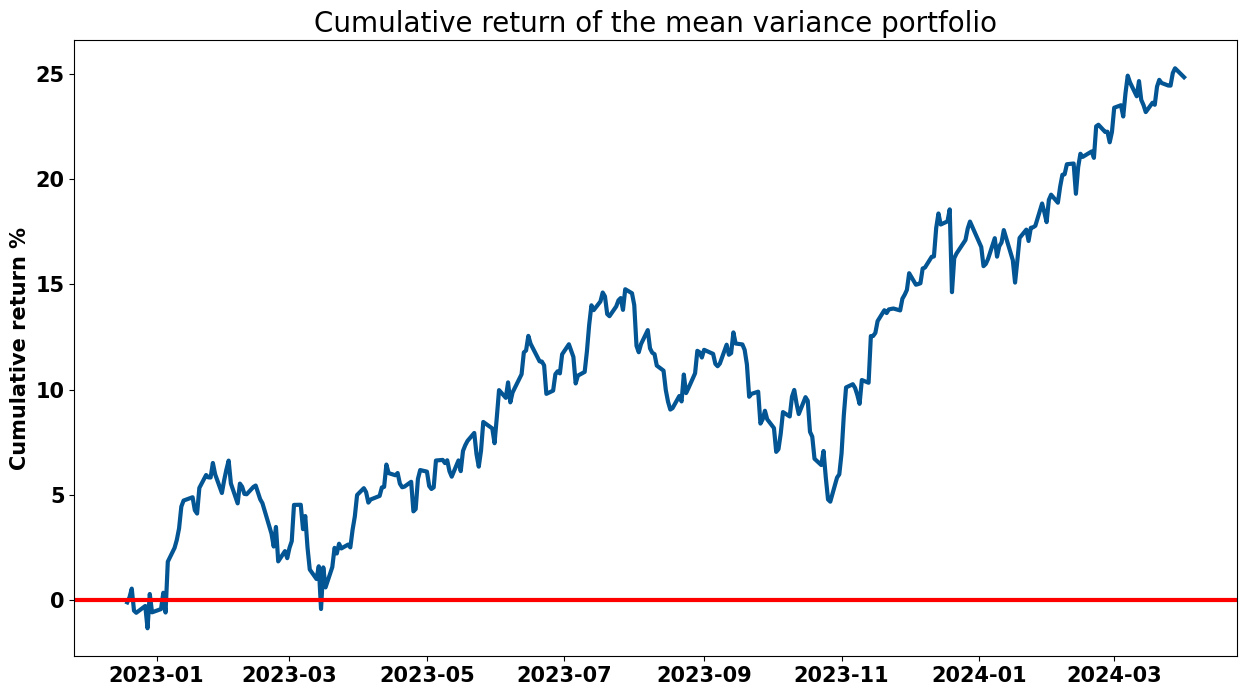

In [6]:
# Calcular la retabilidad acumulada de la cartera
portfolio_return_MV = np.multiply(test_set, np.transpose(X_MV))
portfolio_return_MV = portfolio_return_MV.sum(axis=1)
# Representar el CM
plt.figure(figsize = (15, 8))
plt.plot(np.cumsum(
            portfolio_return_MV)*100,
            color='#035593',
            linewidth=3
         )
plt.ylabel("Cumulative return %",
           size=15,
           fontweight='bold')
plt.xticks(size=15,
           fontweight='bold'
           )
plt.yticks(size=15,
           fontweight='bold'
           )
plt.title("Cumulative return of the mean variance portfolio",
          size=20)
plt.axhline(0, 
            color='r',
            linewidth=3
            )
plt.show()

In [19]:
pd.DataFrame(X_MV*100, columns=['Pesos'], index=df.columns)

,Pesos
EWJ,15.689353
EWT,16.312262
EWY,7.117307
EWZ,0.000000
EZU,10.228420
INDA,25.824728
ITOT,24.827929
MCHI,0.000000
